# Лабораторная работа №7

## Рекуррентные нейронные сети для анализа текста

Набор данных для предсказания оценок для отзывов, собранных с сайта _imdb.com_, который состоит из 50,000 отзывов в виде текстовых файлов.

Отзывы разделены на положительные (25,000) и отрицательные (25,000).

Данные предварительно токенизированы по принципу «мешка слов», индексы слов можно взять из словаря (_imdb.vocab_).

Обучающая выборка включает в себя 12,500 положительных и 12,500 отрицательных отзывов, контрольная выборка также содержит 12,500 положительных и 12,500 отрицательных отзывов.

Данные можно скачать ~~на сайте _Kaggle_~~: ~~https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset~~ https://ai.stanford.edu/~amaas/data/sentiment/

### Задание 1

Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

Будем брать первые `MAX_LENGTH` слов, а если в отзыве слов меньше, чем это число, то применять паддинг.

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
BASE_DIR = '/content/drive/My Drive/Colab Files/mo-2'

import sys

sys.path.append(BASE_DIR)

import os

In [0]:
DATA_ARCHIVE_NAME = 'imdb-dataset-of-50k-movie-reviews.zip'

LOCAL_DIR_NAME = 'imdb-sentiments'

In [0]:
from zipfile import ZipFile

with ZipFile(os.path.join(BASE_DIR, DATA_ARCHIVE_NAME), 'r') as zip_:
    zip_.extractall(LOCAL_DIR_NAME)

In [0]:
DATA_FILE_PATH = 'imdb-sentiments/IMDB Dataset.csv'

In [0]:
import pandas as pd

all_df = pd.read_csv(DATA_FILE_PATH)

In [0]:
df_test = all_df.sample(frac = 0.1)

df_train = all_df.drop(df_test.index)

In [8]:
df_train.shape, df_test.shape

((45000, 2), (5000, 2))

In [9]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
MAX_LENGTH = 40

STRING_DTYPE = '<U12'

PADDING_TOKEN = 'PAD'

LIMIT_OF_TOKENS = 100000

In [0]:
from nltk import word_tokenize
import numpy as np
import string
import re

def tokenize_string(_string):
    return  [tok_.lower() for tok_ in word_tokenize(_string) if not re.fullmatch('[' + string.punctuation + ']+', tok_)]

def pad(A, length):
    arr = np.empty(length, dtype = STRING_DTYPE)
    arr.fill(PADDING_TOKEN)
    arr[:len(A)] = A
    return arr

def tokenize_row(_sentence):
    return pad(tokenize_string(_sentence)[:MAX_LENGTH], MAX_LENGTH)

def encode_row(_label):
    return 1 if _label == 'positive' else 0

def encode_and_tokenize(_dataframe):

    tttt = _dataframe.apply(lambda row: tokenize_row(row['review']), axis = 1)
    llll = _dataframe.apply(lambda row: encode_row(row['sentiment']), axis = 1)

    data_dict_ = { 'label': llll, 'tokens': tttt }

    encoded_and_tokenized_ = pd.DataFrame(data_dict_, columns = ['label', 'tokens'])

    return encoded_and_tokenized_

In [0]:
df_train_tokenized = encode_and_tokenize(df_train)
df_test_tokenized = encode_and_tokenize(df_test)

In [0]:
from collections import Counter

def get_tokens_list(_dataframe):
    
    all_tokens_ = []
    
    for sent_ in _dataframe['tokens'].values:
        all_tokens_.extend(sent_)

    tokens_counter_ = Counter(all_tokens_)
                
    return [t for t, _ in tokens_counter_.most_common(LIMIT_OF_TOKENS)]

In [0]:
tokens_list = get_tokens_list(pd.concat([df_train_tokenized, df_test_tokenized]))

In [0]:
word_to_int_dict = {}

word_to_int_dict.update(
    {t : i for i, t in enumerate(tokens_list)})

In [0]:
def intize_row(_tokens):
    return np.array([word_to_int_dict[t]
                if t in word_to_int_dict
                else 0
            for t in _tokens])

def encode_and_tokenize(_dataframe):

    iiii = _dataframe.apply(lambda row: intize_row(row['tokens']), axis = 1)

    data_dict_ = { 'label': _dataframe['label'], 'ints': iiii }

    intized_ = pd.DataFrame(data_dict_, columns = ['label', 'ints'])

    return intized_

In [0]:
df_train_intized = encode_and_tokenize(df_train_tokenized)
df_test_intized = encode_and_tokenize(df_test_tokenized)

### Задание 2

Реализуйте и обучите двунаправленную рекуррентную сеть (_LSTM_ или _GRU_).

Какого качества классификации удалось достичь?

In [18]:
! pip install tensorflow-gpu --pre --quiet

! pip show tensorflow-gpu

     |████████████████████████████████| 516.2MB 30kB/s 
Name: tensorflow-gpu
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wheel, google-pasta, grpcio, opt-einsum, keras-preprocessing, scipy, tensorflow-estimator, six, astunparse, numpy, termcolor, wrapt, tensorboard, gast, h5py, absl-py, protobuf
Required-by: 


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
# To fix memory leak: https://github.com/tensorflow/tensorflow/issues/33009

tf.compat.v1.disable_eager_execution()

Здесь будем использовать такую конфигурацию рекуррентного _LSTM_-слоя, которая позволит использовать очень быструю _cuDNN_ имплементацию.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

# The requirements to use the cuDNN implementation are:
# 1. `activation` == `tanh`
# 2. `recurrent_activation` == `sigmoid`
# 3. `recurrent_dropout` == 0
# 4. `unroll` is `False`
# 5. `use_bias` is `True`
# 6. `reset_after` is `True`
# 7. Inputs, if use masking, are strictly right-padded.

model = tf.keras.Sequential()

model.add(Bidirectional(LSTM(100, return_sequences = False), merge_mode = 'concat',
          input_shape = (MAX_LENGTH, 1)))
model.add(Dense(1, activation = 'sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200)               81600     
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 81,801
Trainable params: 81,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_intized = np.asarray(list(df_train_intized['ints'].values), dtype = float)[..., np.newaxis]
X_test_intized = np.asarray(list(df_test_intized['ints'].values), dtype = float)[..., np.newaxis]

y_train_intized = np.asarray(list(df_train_intized['label'].values))
y_test_intized = np.asarray(list(df_test_intized['label'].values))

In [24]:
history = model.fit(x = X_train_intized, y = y_train_intized, validation_split = 0.15, epochs = 20)

Train on 38250 samples, validate on 6750 samples
Epoch 1/20
38250/38250 [==============================] - 50s 1ms/sample - loss: 0.6937 - accuracy: 0.5199 - val_loss: 0.6879 - val_accuracy: 0.5447
Epoch 2/20
38250/38250 [==============================] - 49s 1ms/sample - loss: 0.6883 - accuracy: 0.5420 - val_loss: 0.6892 - val_accuracy: 0.5348
Epoch 3/20
38250/38250 [==============================] - 49s 1ms/sample - loss: 0.6859 - accuracy: 0.5495 - val_loss: 0.6883 - val_accuracy: 0.5519
Epoch 4/20
38250/38250 [==============================] - 49s 1ms/sample - loss: 0.6842 - accuracy: 0.5548 - val_loss: 0.6832 - val_accuracy: 0.5538
Epoch 5/20
38250/38250 [==============================] - 48s 1ms/sample - loss: 0.6814 - accuracy: 0.5604 - val_loss: 0.6834 - val_accuracy: 0.5567
Epoch 6/20
38250/38250 [==============================] - 48s 1ms/sample - loss: 0.6795 - accuracy: 0.5670 - val_loss: 0.6835 - val_accuracy: 0.5545
Epoch 7/20
38250/38250 [==============================] -

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

In [26]:
import seaborn as sns

from matplotlib import rcParams

rcParams['figure.figsize'] = 11.7, 8.27

sns.set()

sns.set_palette(sns.color_palette('hls'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


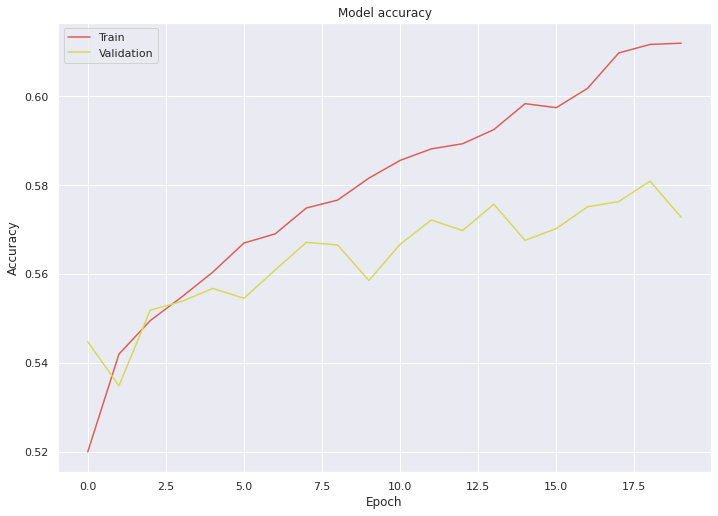

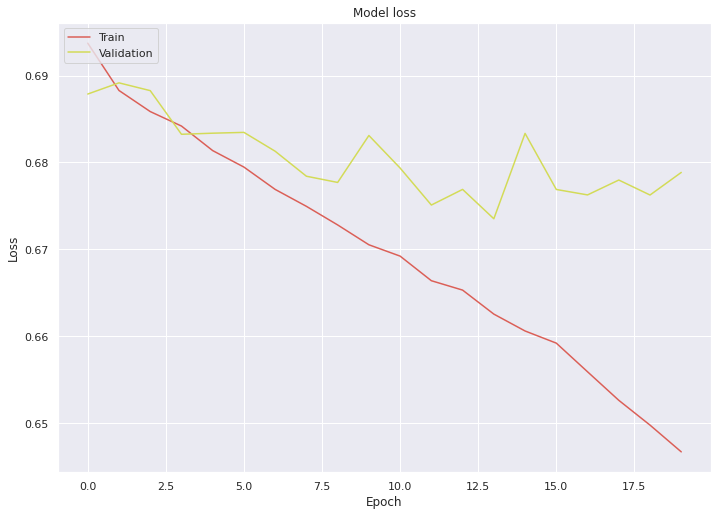

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [28]:
results = model.evaluate(X_test_intized, y_test_intized)

print('Test loss, test accuracy:', results)

Test loss, test accuracy: [0.682829614162445, 0.5698]


На валидационной выборке удалось достичь точности 56%.

### Задание 3

Используйте индексы слов и их различное внутреннее представление (_word2vec_, _glove_). Как влияет данное преобразование на качество классификации?

Используем 300-мерные вектора _FastTest_ &mdash; лучшую на сегодняшний день имплементацию word2vec: https://fasttext.cc/docs/en/english-vectors.html. Файл пришлось доработать &mdash; 9-я строка не читалась.

In [0]:
# VECTORS_ARCHIVE_NAME = 'wiki-news-300d-1M-fixed.zip'

# VECTORS_FILE_NAME = 'wiki-news-300d-1M-fixed.vec'

# VECTORS_LOCAL_DIR_NAME = 'vectors'

In [0]:
# with ZipFile(os.path.join(BASE_DIR, VECTORS_ARCHIVE_NAME), 'r') as zip_:
#     zip_.extractall(VECTORS_LOCAL_DIR_NAME)

Создадим уменьшенный словарь, содержащий только встреченные токены, чтобы уменьшить нагрузку на _Google Drive_:

In [0]:
# def build_vectors_dict(_actual_tokens, _vectors_file_path, _unknown_token = 'unknown'):

#     vec_data_ = pd.read_csv(_vectors_file_path, sep = ' ', header = None, skiprows = [9])
        
#     actual_vectors_ = [x for x in vec_data_.values if x[0] in _actual_tokens or x[0] == _unknown_token]

#     return actual_vectors_

In [0]:
# actual_vectors = build_vectors_dict(tokens_list, os.path.join(VECTORS_LOCAL_DIR_NAME, VECTORS_FILE_NAME))

In [0]:
# vectors_np = np.array(actual_vectors)

# vectors_dict = dict(zip(vectors_np[:, 0], vectors_np[:, 1:]))

# vectors_dict_file_name = 'word-vec-dict-{}-items'.format(len(vectors_dict))

# vectors_dict_file_path = os.path.join(BASE_DIR, vectors_dict_file_name)

# np.savez_compressed(vectors_dict_file_path, vectors_dict, allow_pickle = True)

In [0]:
vectors_dict_file_path = './drive/My Drive/Colab Files/mo-2/word-vec-dict-56485-items.npz'

In [0]:
vectors_dict_data = np.load(vectors_dict_file_path, allow_pickle = True)

vectors_dict = vectors_dict_data['arr_0'][()]

In [0]:
VECTORS_LENGTH = 300

In [0]:
def tokens_to_vectors(_word_to_vec_dict, _tokens, _unknown_token):
    return [_word_to_vec_dict[t]
                if t in _word_to_vec_dict
                else _word_to_vec_dict[_unknown_token]
            for t in _tokens]

def row_to_vectors(_tokens):
    return np.array(tokens_to_vectors(vectors_dict, _tokens, 'unknown'))

def vectorize(_dataframe):

    vvvv = _dataframe.apply(lambda row: row_to_vectors(row['tokens']), axis = 1)

    data_dict_ = { 'label': _dataframe['label'], 'vectors': vvvv }

    vectorized_ = pd.DataFrame(data_dict_, columns = ['label', 'vectors'])

    return vectorized_

In [0]:
df_train_vectorized = vectorize(df_train_tokenized)
df_test_vectorized = vectorize(df_test_tokenized)

In [0]:
X_train_vectorized = np.asarray(list(df_train_vectorized['vectors'].values), dtype = float)
X_test_vectorized = np.asarray(list(df_test_vectorized['vectors'].values), dtype = float)

y_train_vectorized = np.asarray(list(df_train_vectorized['label'].values))
y_test_vectorized = np.asarray(list(df_test_vectorized['label'].values))

In [40]:
model_2 = tf.keras.Sequential()

model_2.add(Bidirectional(LSTM(100, return_sequences = False), merge_mode = 'concat',
            input_shape = (MAX_LENGTH, VECTORS_LENGTH)))
model_2.add(Dense(1, activation = 'sigmoid'))

In [41]:
model_2.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 321,001
Trainable params: 321,001
Non-trainable params: 0
_________________________________________________________________


In [42]:
history_2 = model_2.fit(x = X_train_vectorized, y = y_train_vectorized, validation_split = 0.15, epochs = 20)

Train on 38250 samples, validate on 6750 samples
Epoch 1/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.5449 - accuracy: 0.7137 - val_loss: 0.5143 - val_accuracy: 0.7422
Epoch 2/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.4866 - accuracy: 0.7559 - val_loss: 0.4913 - val_accuracy: 0.7604
Epoch 3/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.4594 - accuracy: 0.7755 - val_loss: 0.4766 - val_accuracy: 0.7618
Epoch 4/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.4364 - accuracy: 0.7881 - val_loss: 0.4598 - val_accuracy: 0.7708
Epoch 5/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.4095 - accuracy: 0.8028 - val_loss: 0.4932 - val_accuracy: 0.7527
Epoch 6/20
38250/38250 [==============================] - 53s 1ms/sample - loss: 0.3818 - accuracy: 0.8222 - val_loss: 0.4736 - val_accuracy: 0.7698
Epoch 7/20
38250/38250 [==============================] -

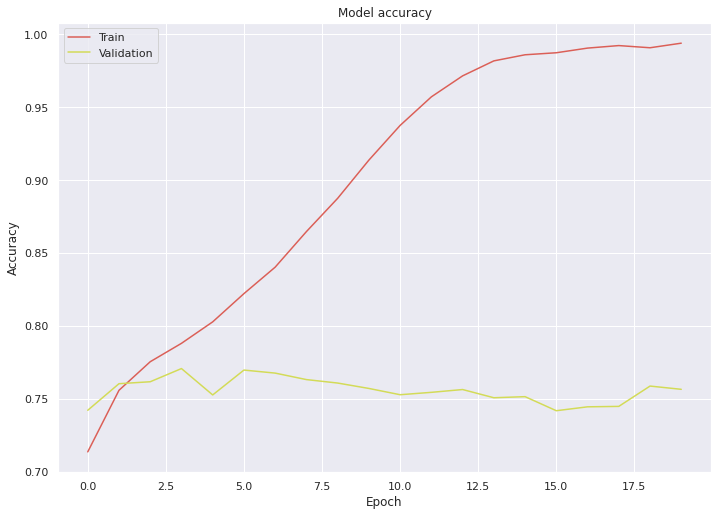

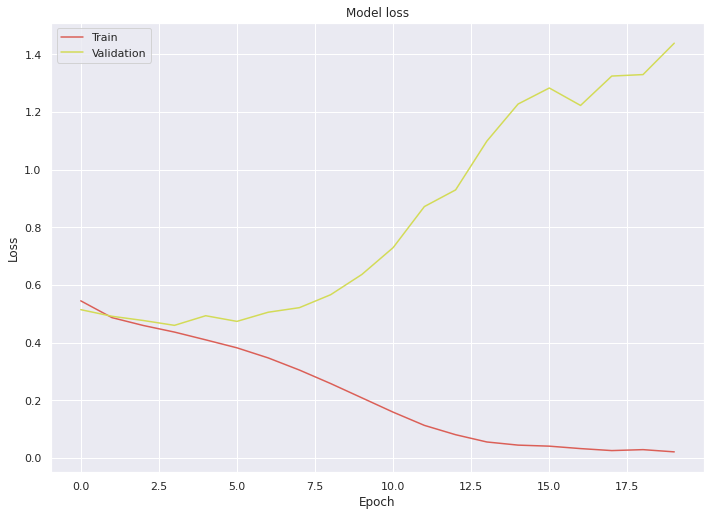

In [43]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [44]:
results_2 = model_2.evaluate(X_test_vectorized, y_test_vectorized)

print('Test loss, test accuracy:', results_2)

Test loss, test accuracy: [1.4954523480892181, 0.7468]


Как и ожидалось, использование эмбеддингов показало лучший результат, чем кодирование слов просто целыми числами &mdash; 74%.

### Задание 4

Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?

In [45]:
model_3 = tf.keras.Sequential()

model_3.add(Bidirectional(LSTM(5, return_sequences = True), merge_mode = 'concat',
            input_shape = (MAX_LENGTH, VECTORS_LENGTH)))
model_3.add(LSTM(1, return_sequences = False))
model_3.add(Dense(10, activation = 'linear'))
model_3.add(Dense(1, activation = 'sigmoid'))

In [46]:
model_3.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 40, 10)            12240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 12,319
Trainable params: 12,319
Non-trainable params: 0
_________________________________________________________________


In [50]:
history_3 = model_3.fit(x = X_train_vectorized, y = y_train_vectorized, validation_split = 0.15, epochs = 20)

Train on 38250 samples, validate on 6750 samples
Epoch 1/20
38250/38250 [==============================] - 84s 2ms/sample - loss: 0.3770 - accuracy: 0.8253 - val_loss: 0.4855 - val_accuracy: 0.7699
Epoch 2/20
38250/38250 [==============================] - 82s 2ms/sample - loss: 0.3720 - accuracy: 0.8275 - val_loss: 0.5009 - val_accuracy: 0.7649
Epoch 3/20
38250/38250 [==============================] - 82s 2ms/sample - loss: 0.3676 - accuracy: 0.8303 - val_loss: 0.4929 - val_accuracy: 0.7756
Epoch 4/20
38250/38250 [==============================] - 82s 2ms/sample - loss: 0.3649 - accuracy: 0.8318 - val_loss: 0.4934 - val_accuracy: 0.7733
Epoch 5/20
38250/38250 [==============================] - 81s 2ms/sample - loss: 0.3603 - accuracy: 0.8339 - val_loss: 0.5004 - val_accuracy: 0.7630
Epoch 6/20
38250/38250 [==============================] - 81s 2ms/sample - loss: 0.3571 - accuracy: 0.8376 - val_loss: 0.5087 - val_accuracy: 0.7677
Epoch 7/20
38250/38250 [==============================] -

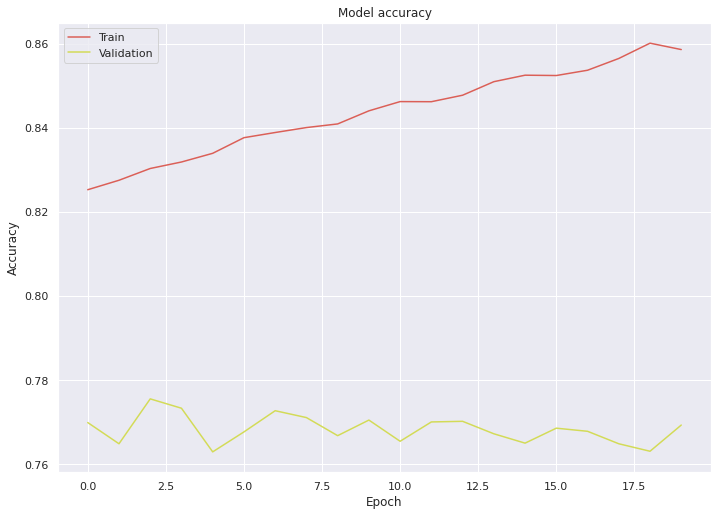

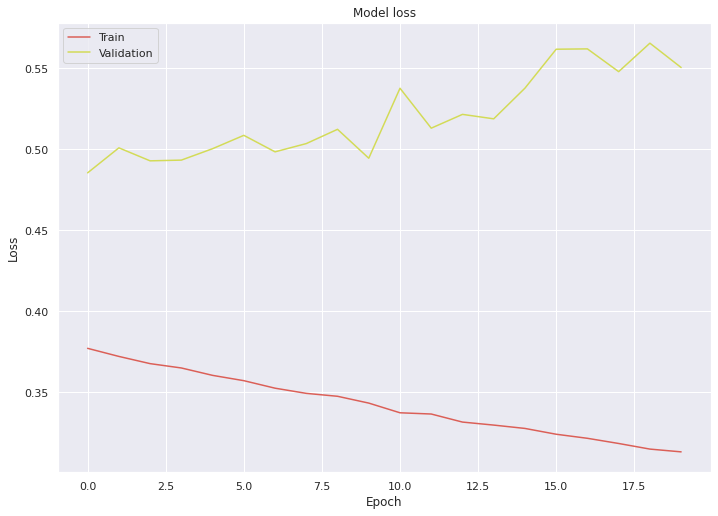

In [51]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [52]:
results_3 = model_3.evaluate(X_test_vectorized, y_test_vectorized)

print('Test loss, test accuracy:', results_3)

Test loss, test accuracy: [0.5695644823074341, 0.7558]


Добавление ещё одного рекуррентного слоя ненамного улучшило результат &mdash; точность 75% на тестовой выборке.

### Задание 5

Используйте предобученную рекуррентную нейронную сеть (например, _DeepMoji_ или что-то подобное).

Какой максимальный результат удалось получить на контрольной выборке?

На своих моделях удалось достигнуть максимальной точности 76%.